In [1]:
import os
import json
#from flask import Flask, request, jsonify, flash, redirect, url_for, send_from_directory
from werkzeug.utils import secure_filename
#from flask_cors import CORS, cross_origin
#import pylibjpeg
from pydicom import dcmread
import scipy.ndimage as ndi
import pandas as pd  
import pydicom, numpy as np
import matplotlib.pylab as plt
import os
import zipfile
import seaborn as sns
from random import randrange
from tqdm.notebook import tqdm
import pickle
import cv2
#from PIL import Image
#import tensorflow as tf
#from tensorflow import keras
from skimage import morphology
import torch
import torch.nn as nn
#import matplotlib.cm as cm
#from PIL import Image as im
import platform

#from lime import lime_image
#from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries, slic

ModuleNotFoundError: No module named 'skimage'

In [2]:
file = "../Model-Implementation/Datasets/AISD/data-examples/dicoms/0021822/CT/000001.dcm"

#'../stroke-backend/New_models/torch_test/efficientnet_v2_l.ckpt'

In [3]:
from scipy.ndimage import binary_erosion, binary_dilation

from scipy.ndimage import label
from skimage.measure import regionprops
from scipy.ndimage import binary_fill_holes



def remove_noise(binary_array, erosion_iterations=2, dilation_iterations=1):
    # Perform erosion to remove small foreground regions
    eroded_array = binary_erosion(binary_array, iterations=erosion_iterations)
    
    # Perform dilation to restore the remaining foreground regions
    dilated_array = binary_dilation(eroded_array, iterations=dilation_iterations)
    
    return dilated_array

def remove_small_regions(binary_array, min_size=100):
    # Label connected regions in the binary array
    labeled_array, num_labels = label(binary_array)
    
    # Get properties of each labeled region
    region_props = regionprops(labeled_array)
    
    # Create an empty array for the output
    filtered_array = np.zeros_like(binary_array, dtype=bool)
    
    # Iterate over the regions and filter based on size
    for region in region_props:
        if region.area >= min_size:
            filtered_array[labeled_array == region.label] = True
    
    return filtered_array

def create_segmentation_mask(img):
    print(img.shape)
    img = np.transpose(img, (1, 2, 0))

    mask = np.full((img.shape[0], img.shape[1]), False, dtype=bool)
    print(img.shape)
    #removes background and bone
    for i in range(224):
        for j in range(224):
            if img[i][j][0] != 0 and img[i][j][1] != 0:
                if img[i][j][0] != 1 and img[i][j][1] != 1:
                    mask[i][j] = True

    #removes noise
    mask = remove_noise(mask)
    #removes additional small noisy regions
    mask = remove_small_regions(mask, min_size=200)
    #removes small areas inside positive regions
    final_mask = binary_fill_holes(mask)

    return final_mask


In [4]:
from scipy.ndimage import binary_erosion, binary_dilation

from scipy.ndimage import label
from skimage.measure import regionprops
from scipy.ndimage import binary_fill_holes



def remove_noise(binary_array, erosion_iterations=2, dilation_iterations=1):
    # Perform erosion to remove small foreground regions
    eroded_array = binary_erosion(binary_array, iterations=erosion_iterations)
    
    # Perform dilation to restore the remaining foreground regions
    dilated_array = binary_dilation(eroded_array, iterations=dilation_iterations)
    
    return dilated_array

def remove_small_regions(binary_array, min_size=100):
    # Label connected regions in the binary array
    labeled_array, num_labels = label(binary_array)
    
    # Get properties of each labeled region
    region_props = regionprops(labeled_array)
    
    # Create an empty array for the output
    filtered_array = np.zeros_like(binary_array, dtype=bool)
    
    # Iterate over the regions and filter based on size
    for region in region_props:
        if region.area >= min_size:
            filtered_array[labeled_array == region.label] = True
    
    return filtered_array

def create_segmentation_mask(img):

    mask = np.full((img.shape[0], img.shape[1]), False, dtype=bool)
    #removes background and bone
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j][0] != 0 and img[i][j][1] != 0:
                if img[i][j][0] != 1 and img[i][j][1] != 1:
                    mask[i][j] = True

    #removes noise
    mask = remove_noise(mask)
    #removes additional small noisy regions
    mask = remove_small_regions(mask, min_size=200)
    #removes small areas inside positive regions
    final_mask = binary_fill_holes(mask)

    return final_mask


from scipy.ndimage.measurements import label
from scipy.spatial.distance import pdist, squareform

def calculate_diameter(binary_array):
    # Label connected components in the binary array
    labeled_array, num_features = label(binary_array)
    
    # Find the labels of the connected components
    labels = np.unique(labeled_array)[1:]  # Exclude background label 0
    
    max_diameter = 0
    
    # Iterate through each label and calculate the diameter
    for label_val in labels:
        # Extract the connected component for the current label
        component = np.where(labeled_array == label_val, 1, 0)
        
        # Find the boundary points of the connected component
        boundary_points = np.argwhere(component == 1)
        
        # Calculate the pairwise distances between the boundary points
        pairwise_distances = pdist(boundary_points, metric='euclidean')
        
        # Find the maximum distance between any two boundary points
        if len(pairwise_distances) > 0:
            max_component_diameter = np.max(pairwise_distances)
            max_diameter = max(max_diameter, max_component_diameter)
    
    return max_diameter

def create_crucial_segmentation_mask(img):
    
    mask = create_segmentation_mask(img)

    final_mask = copy.deepcopy(mask)

    zero_coords = np.where(mask == False)

    _threshold = int(calculate_diameter(mask)*1/5)
    print(_threshold)

    for x, y in np.ndindex(mask.shape):
        # Calculate the distances to the pixels with value 0
        distances = np.sqrt((x - zero_coords[0])**2 + (y - zero_coords[1])**2)
        
        # Check if the minimum distance is greater than the threshold distance
        if np.min(distances) >= _threshold:
            # Change the value of the pixel
            final_mask[x, y] = False

    return final_mask

C:\Users\beckm\AppData\Local\Temp\ipykernel_14260\3661189187.py:55: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [5]:
import math


def transform_to_hu(img, intercept, slope):
    """Transform raw pixel values in CT scans to the Hounsfield Units (HU)
        HU: A standardized scale used to measure tissue density.

    Args:
        img (numpy array): Waw pixel values of CT scan
        intercept (int): Linear attenuation coefficients of the tissues.
        slope (int): Linear attenuation coefficients of the tissues.

    Returns:
        numpy array: Converted HU values from raw pixel values of img
    """
    hu_image = img * slope + intercept

    return hu_image

def window_image(img, window_center, window_width, intercept, slope, rescale=True):
    """Apply windowing to enhance specific regions of interest (brain, bone, subdural)

    Args:
        img (numpy array): Raw pixel values of CT scan
        window_center (int): Midpoint or central value of the selected range of pixel values
        window_width (int): Determine the range of pixel values that will be displayed.
        intercept (int): Linear attenuation coefficient (intercept) of the tissues.
        slope (int): Linear attenuation coefficient (slope) of the tissues.
        rescale (bool, optional): Extra rescaling to 0-1. Defaults to True.

    Returns:
        numpy array: windowed image
    """
    img = transform_to_hu(img, intercept, slope)
    is_zero = img == 0
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max

    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    img[is_zero] = 0
    
    return img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    """Get default windowing value

    Args:
        data (dicom format): Input image for getting windowing values

    Returns:
        int, int, int, int: window_center , window_width, intercept, slope
    """
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
    
def convert_pixelarray_to_rgb(image1, image2, image3):
    """Combine image1, image2, image3 into 3-channels image

    Args:
        image1 (numpy array): Windowed image (Brain)
        image2 (numpy array): Windowed image (Subdural)
        image3 (numpy array): Windowed image (Bone)

    Returns:
        numpy array: Combined 3-channels image
    """

    image = np.zeros((image1.shape[0], image1.shape[1], 3))
    
    image[:,:,0] = image1
    image[:,:,1] = image2
    image[:,:,2] = image3

    return image

def mask_image(brain_image, dilation = 12):
    """Find brain mask

    Args:
        brain_image (numpy array): Windowed image (Brain)
        dilation (int, optional): Dilation distance. Defaults to 12.

    Returns:
        numpy array: Mask image for brain_image
    """
    
    segmentation = morphology.dilation(brain_image, np.ones((dilation, dilation)))
    labels, label_nb = ndi.label(segmentation)

    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0
    mask = labels == label_count.argmax()
    mask = morphology.dilation(mask, np.ones((3, 3)))
    mask = ndi.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
        
    return mask

def align_image(image, image_annotaion = None):
    """Align brain image symmetrically

    Args:
        image (numpy array): Mask image of brain image

    Returns:
        numpy array: Aligned brain image
    """

    img=np.uint8(image)
    contours, hier =cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # find the biggest contour (c) by the area
    c = max(contours, key = cv2.contourArea)

    try:
        (x,y),(MA,ma),angle = cv2.fitEllipse(c)
    except:
        return img

    cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(MA,ma)/2
    if angle > 90:
        angle -= 90
    else:
        angle += 96
    xtop = x + math.cos(math.radians(angle))*rmajor
    ytop = y + math.sin(math.radians(angle))*rmajor
    xbot = x + math.cos(math.radians(angle+180))*rmajor
    ybot = y + math.sin(math.radians(angle+180))*rmajor
    cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

    M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

    img = cv2.warpAffine(image, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)
    if image_annotaion.any():
        image_annotaion = cv2.warpAffine(image_annotaion, M, (image_annotaion.shape[1], image_annotaion.shape[0]), cv2.INTER_CUBIC)
    return img, image_annotaion

def center_image(image, com, dim):
    # image centering

    if dim == 3:
        height, width, _ = image.shape
        shift = (height/2-com[0], width/2-com[1], 0)
    else:
        height, width = image.shape
        shift = (height/2-com[0], width/2-com[1])
    res_image = ndi.shift(image, shift)
    return res_image

def scale_image(image, mask, img_annotation = None):
    """Scale the brain image to its full size within the image.

    Args:
        image (numpy array): Input brain image
        mask (numpy array): Mask image of brain image

    Returns:
        numpy array: Scaled brain image
    """

    height, width = image.shape
    coords = np.array(np.nonzero(mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    cropped_image = image[top_left[0]:bottom_right[0],
                            top_left[1]:bottom_right[1]]
    if img_annotation.any():
        cropped_img_annotation = img_annotation[top_left[0]:bottom_right[0],
                            top_left[1]:bottom_right[1]]
    hc, wc = cropped_image.shape
    
    size = np.max([hc, wc])

    top_left = int((size - hc) / 2)
    bottom_right = int((size - wc) / 2)

    cropped_img_sqr = np.zeros((size, size))
    cropped_img_sqr[top_left:top_left+hc, bottom_right:bottom_right+wc] = cropped_image
    cropped_img_sqr = cv2.resize(cropped_img_sqr, (height,width), interpolation=cv2.INTER_LINEAR)
    
    cropped_img_sqr_annotation = None
    if img_annotation.any():
        cropped_img_sqr_annotation = np.zeros((size, size))
        cropped_img_sqr_annotation[top_left:top_left+hc, bottom_right:bottom_right+wc] = cropped_img_annotation
        cropped_img_sqr_annotation = cv2.resize(cropped_img_sqr_annotation, (height,width), interpolation=cv2.INTER_LINEAR)
        
    return cropped_img_sqr, cropped_img_sqr_annotation

def is_small_mask(mask, image, threshold=0.1):
    """
    Check the brain covers less than a threshold portion of the original image.
    Args:
        mask (numpy array): Binary mask of the image.
        images (numpy array): Input image for checking brain size.
        threshold (float): Minimum portion of the image that the mask must cover.
    Returns:
        Boolean. True, if the mask is smaller than the threshold.
                 False, otherwise.
    """
    isSmallMask = False
    image_size = np.prod(image.shape)
    mask_size = np.count_nonzero(mask)
    mask_coverage = mask_size / image_size
    if mask_coverage < threshold:
        isSmallMask = True
    
    return isSmallMask
    
def apply_windowing(data, image_annotaion = None):

    data = pydicom.read_file(data)
    """
    Apply data preprocessing steps:
        Image Denoising
        Image Alignment
        Image Scaling
        Image Centering
        Image Windowing
        Image Resizing
    
    If brain size is too small only proceed with:
        Image Centering
        Image Windowing
        Image Resizing
    Args:
        Dicom: input dicom image for preprocessing
    Returns:
        Dicom: preprocessed image before windowing and resizing
        Numpy Array: preprocessed image (224, 224, 3)
    """
    
    img = data.pixel_array
    window_center , window_width, intercept, slope = get_windowing(data)
    
    dicom_preprocess = data # for display preprocessed image after prediction
 
    brain_image = window_image(img, 40, 80, intercept, slope) #bone windowing
    image_mask = mask_image(brain_image)
    
    # exclude small brain image - too small for detecting stroke
    # need additional process for handling a label and training
    if not is_small_mask(image_mask, img):
        img = image_mask * img
        img, image_annotaion = align_image(img, image_annotaion)
        img, image_annotaion = scale_image(img, image_mask, image_annotaion)
        
    else:
        com = np.average(np.nonzero(brain_image), axis=1)
        img = center_image(img, com, img.ndim) # no needs for centering, applied in scaling step
    
    # save preprocessed dicom image for displaying after prediction (without windowing, resizing)
    img_uint16 = img.astype(np.uint16)
    dicom_preprocess.PixelData = img_uint16.tobytes()
    print(f"shape: {img.shape}, type: "+ str(type(img[0][0])))
    
    # windowing: brain, subdural, bone
    img2 = window_image(img, 40, 80, intercept, slope)
    img3 = window_image(img, 80, 200, intercept, slope)
    img4 = window_image(img, 600, 2800, intercept, slope)

    # combine 3 images into RGB channels
    img = convert_pixelarray_to_rgb(img2, img3, img4)

    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
    if image_annotaion.any():
        image_annotaion = cv2.resize(image_annotaion, (224,224), interpolation=cv2.INTER_LINEAR)
    img_preprocess = img 
    
    return dicom_preprocess, img_preprocess, image_annotaion

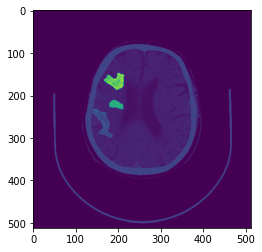

In [6]:
from PIL import Image

file_mask = "../Model-Implementation/Datasets/AISD/data-examples/mask/0072680/008.png"
file_scan = "../Model-Implementation/Datasets/AISD/data-examples/image/0072680/008.png"
file = "../Model-Implementation/Datasets/AISD/data-examples/dicoms/0072680/CT/000008.dcm"

image_mask = np.array(Image.open(file_mask))
image_scan = np.array(Image.open(file_scan))
fig, ax = plt.subplots()
combined_image = np.multiply(image_mask+0.5, image_scan)
ax.imshow(combined_image)
plt.show()

In [ ]:
def create_bounding_box(mask_array):
    # Find the indices of True elements in the mask_array
    true_indices = np.where(mask_array)

    if len(true_indices[0]) == 0:
        # No True elements found, return an empty box
        return None

    # Calculate the minimum and maximum indices along each axis
    min_y, min_x = np.min(true_indices[0]), np.min(true_indices[1])
    max_y, max_x = np.max(true_indices[0]), np.max(true_indices[1])

    # Create the bounding box
    bounding_box = (min_y, min_x, max_y, max_x)

    return bounding_box

In [29]:
def create_bounding_boxes(mask_array): 
	# Find the connected components and their labels
	labeled_array, num_features = label(mask_array)

	# List to store the bounding boxes
	bounding_boxes = []

	for label_idx in range(1, num_features + 1):
		# Create a mask for the current connected component
		component_mask = labeled_array == label_idx

		# Find the indices of True elements in the current component
		true_indices = np.where(component_mask)

		if len(true_indices[0]) == 0:
		# No True elements found, skip this component
			continue

		# Calculate the minimum and maximum indices along each axis for the current component
		min_y, min_x = np.min(true_indices[0]), np.min(true_indices[1])
		max_y, max_x = np.max(true_indices[0]), np.max(true_indices[1])

		# Create the bounding box for the current component
		bounding_box = (min_y, min_x, max_y, max_x)

		# Append the bounding box to the list
		bounding_boxes.append(bounding_box)

	return bounding_boxes

shape: (512, 512), type: <class 'numpy.float64'>


[(63, 47, 89, 78), (105, 61, 116, 83), (123, 38, 162, 73)]

In [1]:
from matplotlib import patches
import warnings
warnings.filterwarnings("ignore")

def draw_rectangles_mask(file, image_mask):
    
    dicom_preprocess, data, preprocessed_mask = apply_windowing(file, image_mask)
    data = np.array(data).astype(np.float32)

    # Display the image using matplotlib
    test_arr = np.round(preprocessed_mask) != 0

    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(data)

    bounding_boxes = create_bounding_boxes(test_arr)
    
    binary_array = np.zeros(test_arr.shape, dtype=bool)
    
    for box in bounding_boxes:
        
        y_min, x_min, y_max, x_max = box
        
        print (y_min, x_min, y_max, x_max)

        width = x_max - x_min
        height = y_max - y_min
        
        plt.imshow(test_arr, alpha=0.8, cmap='jet', extent=(0, data.shape[1], data.shape[0], 0))
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Set the elements within the rectangle to True
        binary_array[y_min:y_max+1, x_min:x_max+1] = True

    plt.show()
    return binary_array

In [2]:
object_box = draw_rectangles_mask(file, image_mask)

NameError: name 'file' is not defined